In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import mfmodel as mfm
import numba as nb

from scipy.sparse import coo_matrix
from scipy.linalg import block_diag, pinvh

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 800
signal_to_noise = 4


nsamples = 20
L = 5

# ranks = np.array([5, 4, 3, 2, 1])
ranks = np.array([10, 7, 5, 4, 1])
rank = ranks.sum()

In [24]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=800.0
level=1, num_groups=3, mean_size=266.7
level=2, num_groups=7, mean_size=114.3
level=3, num_groups=16, mean_size=50.0
level=4, num_groups=800, mean_size=1.0


In [25]:
hpart['rows']['lk'][:-1]

[array([  0, 800]),
 array([  0, 200, 400, 800]),
 array([  0, 100, 200, 300, 400, 600, 700, 800]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800])]

In [26]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=True)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=26.197446571346735, noise_var=6.7834716442654335
SNR=3.8619526910668758, signal_to_noise=4


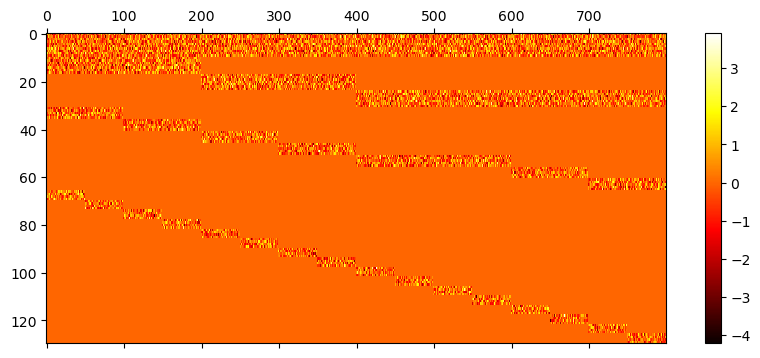

(800, 130)


In [27]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [28]:
type(true_sparse_F)

numpy.ndarray

In [29]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [30]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  6 15]


In [31]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0
pi = F_hpart['pi']
F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]
v = np.random.randn(n)

In [32]:
A = np.random.randn(40,40)
A = A @ A.T + 1e-3
B = np.random.randn(40,40)

eigvals, eigvecs = np.linalg.eigh(A)

Lambda_inv_sqrt = 1 / np.sqrt(eigvals)
A_inv_sqrt = (Lambda_inv_sqrt * eigvecs) @ eigvecs.T

result = B @ A_inv_sqrt
assert np.allclose(result @ result.T, B @ np.linalg.inv(A) @ B.T)
assert np.allclose(A_inv_sqrt @ A_inv_sqrt, np.linalg.inv(A))

In [33]:
list(reversed(range(1, L-1))), L

([3, 2, 1], 5)

In [34]:
ranks[:0].sum()

0

In [35]:
def fast_mfm_inverse_basic(ranks, F_Lm1, D, F_hpart):
    prev_l_recurrence = (1/D[:, np.newaxis]) * F_Lm1
    n = F_Lm1.shape[0]
    H_Lm1 = np.zeros(F_Lm1.shape)
    L = len(F_hpart['lk']) + 1
    for level in reversed(range(0, L-1)):
        pl = F_hpart['lk'][level].size - 1
        rl = ranks[level]
        # M0 same sparsity as Fl
        M0 = prev_l_recurrence[:, -ranks[level]:]
        # M1 = M0.T @ rec_term, same sparsity as rec_term
        M1 = np.zeros((rl * pl, ranks[:level].sum()))
        for lp in range(level):
            M1[:, ranks[:lp].sum() : ranks[:lp+1].sum()] = mfm.mult_blockdiag_refined_AtB(M0, 
                                                                                F_hpart['lk'][level], 
                                                                                F_Lm1[:, ranks[:lp].sum():ranks[:lp+1].sum()], 
                                                                                F_hpart['lk'][lp])
        M1_lks = [np.searchsorted(F_hpart['lk'][level], lk_B, side='left') * rl for lk_B in F_hpart['lk'][:level]]
        # M2 = (I + Fl^T M0)^{-1}, blockdiagonal with pl blocks of size (rl x rl)
        FlTM0 = mfm.mult_blockdiag_refined_AtB(F_Lm1[:, ranks[:level].sum() : ranks[:level+1].sum()], 
                                        F_hpart['lk'][level], 
                                        M0, 
                                        F_hpart['lk'][level])
        M2 = np.zeros((pl*rl, rl))
        sqrt_M2 = np.zeros((pl*rl, rl))
        for k in range(pl):
            np.fill_diagonal(FlTM0[k*rl : (k+1)*rl], FlTM0[k*rl : (k+1)*rl].diagonal() + 1)
            eigvals, eigvecs = np.linalg.eigh(FlTM0[k*rl : (k+1)*rl])
            sqrt_M2[k*rl : (k+1)*rl] = ((1 / np.sqrt(eigvals)) * eigvecs) @ eigvecs.T
            M2[k*rl : (k+1)*rl] = ((1/eigvals) * eigvecs) @ eigvecs.T
            # M2[k*rl : (k+1)*rl] = pinvh(FlTM0[k*rl : (k+1)*rl])
            assert np.allclose(M2[k*rl : (k+1)*rl], pinvh(FlTM0[k*rl : (k+1)*rl]))
            del eigvals, eigvecs
        del FlTM0
        # print(level, H_Lm1[:, ranks[:level].sum():ranks[:level+1].sum()].shape, 
        #       M0.shape, sqrt_M2.shape, F_hpart['lk'][level].size, np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int).size)
        H_Lm1[:, ranks[:level].sum():ranks[:level+1].sum()] = mfm.mult_blockdiag_refined_AB(M0, 
                                                                                        F_hpart['lk'][level],
                                                                                        sqrt_M2, 
                                                                                        np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int))
        del sqrt_M2
        # M3 = M2 @ M1, same sparsity as M1
        M3 = np.zeros((rl * pl, ranks[:level].sum()))
        for lp in range(level):
            M3[:, ranks[:lp].sum():ranks[:lp+1].sum()] = mfm.mult_blockdiag_refined_AtB(M2, 
                                                                                        np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), 
                                                                                        M1[:, ranks[:lp].sum():ranks[:lp+1].sum()], 
                                                                                        M1_lks[lp])
        del M1, M2
        # M4 = M0 @ M3, same sparsity as current rec_term
        M4 = np.zeros((n, ranks[:level].sum()))
        for lp in range(level):
            M4[:, ranks[:lp].sum() : ranks[:lp+1].sum()] = mfm.mult_blockdiag_refined_AB(M0, 
                                                                                        F_hpart["lk"][level], 
                                                                                        M3[:, ranks[:lp].sum():ranks[:lp+1].sum()], 
                                                                                        M1_lks[lp])
        del M0, M3
        # M5  
        prev_l_recurrence = prev_l_recurrence[:, :ranks[:level].sum()] - M4
        del M4
    return H_Lm1 

In [36]:
H_Lm1 = fast_mfm_inverse_basic(ranks, F_Lm1, D, F_hpart)

In [37]:
H_Lm1.max(), np.median(H_Lm1), H_Lm1.mean(), H_Lm1.min()

(58.02848089314506,
 -0.00018324943136857844,
 0.008093062584513774,
 -3.1102223614901208)

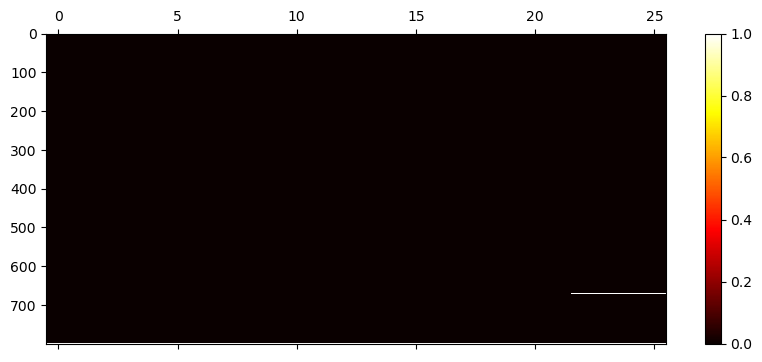

(800, 130)


In [38]:
plt.figure(figsize=(10, 4)) 
plt.matshow(np.abs(H_Lm1)>10, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [39]:
true_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F_Lm1, D=D)
true_mfm.H = H_Lm1
true_mfm.inv_D = 1/D

In [40]:
mf.rel_diff(true_mfm.inv(), np.linalg.inv(true_mlr.matrix()))

1.3663148969904038e-10

In [12]:
true_mlr.construct_sparse_format()
hat_x = mfm.iterative_refinement(ranks, v[:, np.newaxis], F_Lm1, D, F_hpart, eps=1e-12, max_iter=50)
np.linalg.norm(hat_x - np.linalg.inv(true_mlr.matrix()) @ v[:, np.newaxis])

5.419855018890224e-13

In [13]:
for _ in range(10):
    v = np.random.randn(n)
    hat_x = mfm.iterative_refinement(ranks, v[:, np.newaxis], F_Lm1, D, F_hpart, eps=1e-12, max_iter=50)
    reldiff = np.linalg.norm(hat_x - np.linalg.inv(true_mlr.matrix()) @ v[:, np.newaxis]) / np.linalg.norm(v)
    print(f"{reldiff=}")
    assert reldiff < 1e-9

reldiff=7.168094242439308e-15
reldiff=1.1215382216556152e-14
reldiff=1.01493632122391e-14
reldiff=1.1231885398439103e-14
reldiff=7.536642725702468e-15
reldiff=1.050334297642487e-14
reldiff=8.332249907318169e-15
reldiff=1.1445149969597785e-14
reldiff=6.693877033120625e-15
reldiff=9.193288148228631e-15


In [14]:
hat_x = mfm.fast_SMW_inverse(ranks, v, F_Lm1, D, F_hpart)
np.linalg.norm(hat_x - np.linalg.inv(true_mlr.matrix()) @ v[:, np.newaxis])

3.938862084412732e-12

In [15]:
np.linalg.norm(hat_x - np.linalg.solve(true_mlr.matrix(), v[:, np.newaxis])) / np.linalg.norm(v)

1.1900588401758816e-13

# Test matmul

In [18]:
pi = F_hpart['pi']
F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]

In [19]:
for _ in range(100):
    v = np.random.randn(n, 1)
    Av = mfm.mfm_matvec(true_compressed_F, D, F_hpart, ranks, v)
    reldiff = np.linalg.norm(Av - true_mlr.matvec(v)) / np.linalg.norm(v)
    assert reldiff < 1e-9, print(f"{reldiff=}")
print("PASSED")

PASSED


# Test $\mathop{diag}(\tilde F \tilde F^T)$

In [23]:
for _ in range(100):
    F0 = np.random.randn(F_Lm1.shape[0], F_Lm1.shape[1])
    d1 = np.diag(mfm.perm_tildeF_tildeFt(F0, F_hpart, ranks))
    d2 = mfm.diag_sparse_FFt(F0, F_hpart, ranks)
    assert np.allclose(d1, d2)

print("PASSED")

PASSED
